In [ ]:
!pip install albumentations ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.3/887.3 kB 51.3 MB/s eta 0:00:00


In [ ]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Setup complete ✅ (12 CPUs, 53.0 GB RAM, 32.5/112.6 GB disk)


In [ ]:
import pandas as pd
import numpy as np
import os
import os.path as osp
import random
import re
import shutil

#Visualización de datos
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from IPython.display import display, Image
from numpy import asarray
from PIL import Image
from ultralytics import YOLO # En este segmento desde ultralytics importamos el modelo preentrenado YOLO

In [ ]:
import os.path as osp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np

def show_img_matrix(image_list, show_axis=False):
    MAX_SIZE = 9  # La cuadrícula es de 3x3
    if len(image_list) != MAX_SIZE:
        print(f"Error: Se requieren exactamente {MAX_SIZE} imágenes para mostrar la cuadrícula.")
        return

    plt.figure(figsize=(10, 10))

    for i in range(MAX_SIZE):
        img_file = image_list[i]
        img_name = osp.basename(img_file)

        # Subplot 3x3
        ax = plt.subplot(3, 3, i + 1)

        if osp.exists(img_file):
            img = np.array(Image.open(img_file))  # Leer la imagen como array
            plt.imshow(img)
            plt.title(img_name[:20])  # Mostrar el nombre de la imagen, recortado a 20 caracteres
            plt.axis("on" if show_axis else "off")  # Mostrar o no los ejes
        else:
            print(f"Advertencia: {img_file} no se encontró.")

    plt.tight_layout()
    plt.show()

## Mover archivos y labels a las carpetas de entrenamiento

In [ ]:
ROOT_DIR = '/content'
DATASET_NAME = "augmented_images"

In [ ]:
%cd {ROOT_DIR}
!mkdir /{DATASET_NAME}
!unzip {DATASET_NAME}.zip -d {ROOT_DIR}/{DATASET_NAME}

/content
mkdir: cannot create directory ‘/augmented_images’: File exists
Archive:  augmented_images.zip
   creating: /content/augmented_images/augmented_images/
  inflating: /content/augmented_images/augmented_images/68_crop_3_aug_5.jpg  
  inflating: /content/augmented_images/augmented_images/50_crop_8_aug_1.jpg  
  inflating: /content/augmented_images/augmented_images/17_crop_5_aug_6.jpg  
  inflating: /content/augmented_images/augmented_images/72_crop_8_aug_2.jpg  
  inflating: /content/augmented_images/augmented_images/71_crop_22_aug_1.jpg  
  inflating: /content/augmented_images/augmented_images/46_crop_2_aug_6.jpg  
  inflating: /content/augmented_images/augmented_images/73_crop_16_aug_8.jpg  
  inflating: /content/augmented_images/augmented_images/18_crop_18_aug_6.jpg  
  inflating: /content/augmented_images/augmented_images/52_crop_11_aug_3.jpg  
  inflating: /content/augmented_images/augmented_images/73_crop_6_aug_3.jpg  
  inflating: /content/augmented_images/augmented_images

In [ ]:
import os
import shutil
import random
from PIL import Image
import numpy as np

# Directorios originales y destino
images_path = 'augmented_images/augmented_images'
labels_path = 'augmented_images/augmented_labels'

train_images_path = 'datasets/images/train'
val_images_path = 'datasets/images/val'
test_images_path = 'datasets/images/test'
train_labels_path = 'datasets/labels/train'
val_labels_path = 'datasets/labels/val'
test_labels_path = 'datasets/labels/test'

# Crear carpetas
for path in [train_images_path, val_images_path, test_images_path,
             train_labels_path, val_labels_path, test_labels_path]:
    os.makedirs(path, exist_ok=True)

# Splits
train_split, val_split, test_split = 0.7, 0.2, 0.1

def normalize_label(label_path, img_width, img_height):
    """Normaliza las etiquetas y corrige valores negativos"""
    try:
        with open(label_path, 'r') as f:
            lines = f.readlines()

        normalized_lines = []
        for line in lines:
            values = [float(x) for x in line.strip().split()]
            if len(values) != 5:
                continue

            # Corregir valores negativos y normalizar
            class_id = 0
            x_center = abs(values[1])  # Usar valor absoluto para coordenadas
            y_center = abs(values[2])
            width = abs(values[3])     # Usar valor absoluto para dimensiones
            height = abs(values[4])

            # Asegurar que están en rango 0-1
            x_center = min(max(x_center, 0), 1)
            y_center = min(max(y_center, 0), 1)
            width = min(max(width, 0.01), 1)    # Mínimo 1% del ancho
            height = min(max(height, 0.01), 1)   # Mínimo 1% del alto

            normalized_line = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n"
            normalized_lines.append(normalized_line)

        return normalized_lines
    except Exception as e:
        print(f"Error procesando {label_path}: {str(e)}")
        return None

In [ ]:
def move_and_normalize_files(file_list, src_img_dir, src_lbl_dir, dest_img_dir, dest_lbl_dir):
    valid_files = 0
    for file_name in file_list:
        img_src = os.path.join(src_img_dir, file_name)
        lbl_src = os.path.join(src_lbl_dir, file_name.replace('.jpg', '.txt'))

        # Verificar si existen tanto la imagen como la etiqueta
        if not (os.path.exists(img_src) and os.path.exists(lbl_src)):
            print(f"Saltando {file_name}: Falta imagen o etiqueta")
            continue

        try:
            # Leer dimensiones de la imagen
            with Image.open(img_src) as img:
                img_width, img_height = img.size

            # Normalizar etiquetas
            normalized_lines = normalize_label(lbl_src, img_width, img_height)
            if not normalized_lines:
                print(f"Saltando {file_name}: Error en etiquetas")
                continue

            # Si hay etiquetas válidas, copiar imagen y guardar etiquetas normalizadas
            if normalized_lines:
                img_dest = os.path.join(dest_img_dir, file_name)
                lbl_dest = os.path.join(dest_lbl_dir, file_name.replace('.jpg', '.txt'))

                # Copiar imagen
                shutil.copy(img_src, img_dest)

                # Guardar etiquetas normalizadas
                with open(lbl_dest, 'w') as f:
                    f.writelines(normalized_lines)

                valid_files += 1

        except Exception as e:
            print(f"Error procesando {file_name}: {str(e)}")
            continue

    return valid_files

In [ ]:
# Filtrar solo archivos de imagen válidos que tienen etiquetas
image_files = []
for img_file in os.listdir(images_path):
    if img_file.endswith('.jpg'):
        lbl_file = os.path.join(labels_path, img_file.replace('.jpg', '.txt'))
        if os.path.exists(lbl_file):
            image_files.append(img_file)

# Mezclar y dividir
random.shuffle(image_files)
num_train = int(len(image_files) * train_split)
num_val = int(len(image_files) * val_split)

train_files = image_files[:num_train]
val_files = image_files[num_train:num_train + num_val]
test_files = image_files[num_train + num_val:]

# Procesar cada conjunto
print("\nProcesando conjunto de entrenamiento:")
train_count = move_and_normalize_files(train_files, images_path, labels_path, train_images_path, train_labels_path)

print("\nProcesando conjunto de validación:")
val_count = move_and_normalize_files(val_files, images_path, labels_path, val_images_path, val_labels_path)

print("\nProcesando conjunto de prueba:")
test_count = move_and_normalize_files(test_files, images_path, labels_path, test_images_path, test_labels_path)

print(f"\nResumen:")
print(f"Imágenes de entrenamiento procesadas: {train_count}")
print(f"Imágenes de validación procesadas: {val_count}")
print(f"Imágenes de prueba procesadas: {test_count}")


Procesando conjunto de entrenamiento:
Saltando 19_crop_10_aug_7.jpg: Error en etiquetas
Saltando 47_crop_20_aug_2.jpg: Error en etiquetas

Procesando conjunto de validación:

Procesando conjunto de prueba:

Resumen:
Imágenes de entrenamiento procesadas: 1100
Imágenes de validación procesadas: 315
Imágenes de prueba procesadas: 158


## Entrenamiento y busqueda de hiperparametros

In [ ]:
ROOT_DIR = '/content'
DATASET_NAME = "datasets"

In [ ]:
images_folder = f"./{DATASET_NAME}/images/"
label_folder = f"./{DATASET_NAME}/labels/"

In [ ]:
train_img_folder = osp.join(images_folder, "train")
test_img_folder = osp.join(images_folder, "test")
valid_img_folder = osp.join(images_folder, "val")

train_lbl_folder = osp.join(label_folder, "train")
test_lbl_folder = osp.join(label_folder, "test")
valid_lbl_folder = osp.join(label_folder, "val")

In [ ]:
img_list = [filename for filename in os.listdir(train_img_folder)]
img_count = len(img_list)
img_list_test = [filename for filename in os.listdir(test_img_folder)]
img_count_test = len(img_list_test)
img_list_val = [filename for filename in os.listdir(valid_img_folder)]
img_count_val = len(img_list_val)
print(f"El número total de imágenes en train es: {img_count}")
print(f"El número total de imágenes en test es: {img_count_test}")
print(f"El número total de imágenes en validation es: {img_count_val}")

El número total de imágenes en train es: 1100
El número total de imágenes en test es: 158
El número total de imágenes en validation es: 315


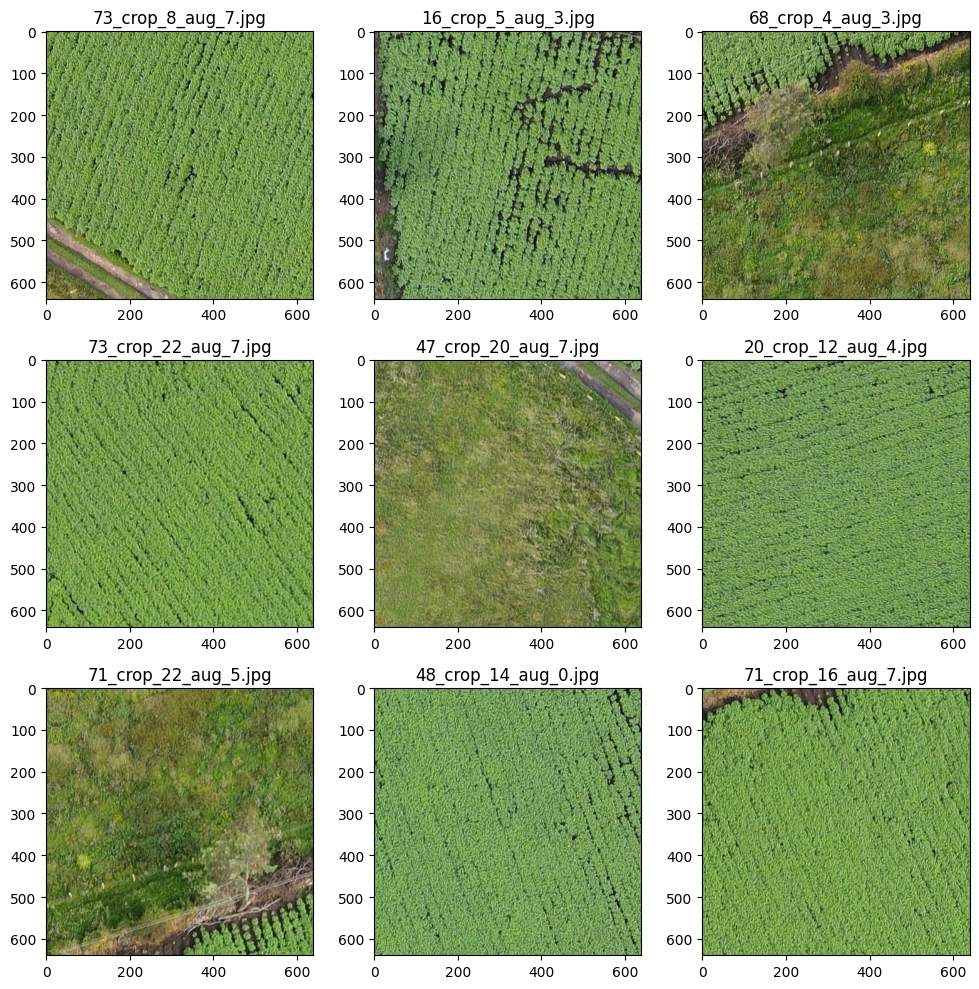

In [ ]:
img_fc_list = [osp.join(train_img_folder, filename) for filename in img_list]
show_img_matrix(img_fc_list[0:9], show_axis=True)

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Directorios de imágenes y etiquetas
images_path = '/content/datasets/images/train/'
labels_path = '/content/datasets/labels/train/'

# Dimensiones objetivo (ejemplo 416x416 para YOLO)
img_size = (640, 640)

# Función para cargar y preprocesar una imagen
def load_and_preprocess_image(img_name):
    img_path = os.path.join(images_path, img_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"No se encontró la imagen: {img_name}")
        return None
    img = cv2.resize(img, img_size)
    img = img / 255.0  # Normalización a rango [0, 1]
    return img

# Función para cargar las etiquetas correspondientes
def load_labels(label_name):
    label_path = os.path.join(labels_path, label_name)
    if not os.path.exists(label_path):
        print(f"No se encontró el archivo de etiquetas: {label_name}")
        return []
    with open(label_path, 'r') as f:
        labels = [list(map(float, line.strip().split())) for line in f]
    return labels

# Función para visualizar la imagen con las etiquetas
def visualize_image_with_labels(img_name):
    # Cargar imagen y etiquetas
    img = load_and_preprocess_image(img_name)
    label_name = img_name.replace('.jpg', '.txt')
    labels = load_labels(label_name)

    if img is None:
        return

    # Convertir imagen al formato RGB para visualizar con Matplotlib
    img_rgb = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    for label in labels:
        class_id, x_center, y_center, width, height = label
        x_center, y_center, width, height = (
            x_center * img_size[0], y_center * img_size[1],
            width * img_size[0], height * img_size[1]
        )
        top_left = (int(x_center - width / 2), int(y_center - height / 2))
        bottom_right = (int(x_center + width / 2), int(y_center + height / 2))
        plt.gca().add_patch(plt.Rectangle(top_left, width, height, linewidth=2, edgecolor='green', facecolor='none'))
        plt.text(top_left[0], top_left[1] - 5, f"Clase {int(class_id)}", color='green', fontsize=10)

    plt.axis('off')
    plt.show()

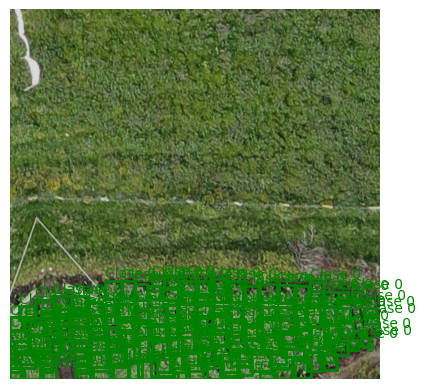

In [ ]:
visualize_image_with_labels('16_crop_11_aug_0.jpg')

In [ ]:
class_names = ["potato"]

In [ ]:
yaml_content = f"""\
path: {ROOT_DIR}   # Directorio raiz de los datos
train: {DATASET_NAME}/images/train  # Ruta relativa a los datos de entrenamiento
val: {DATASET_NAME}/images/val  # Ruta relativa a los datos de validacion
test: {DATASET_NAME}/images/test # Ruta relativa a los datos de prueba

# Classes
nc: {len(class_names)}

names: {class_names}
"""

YAML_PATH = f'{ROOT_DIR}/potatotes_v8.yaml'

if osp.exists(YAML_PATH):
  os.remove(YAML_PATH)

# Guardar el archivo YAML
with open(YAML_PATH, 'w') as yaml_file:
  yaml_file.write(yaml_content)

In [ ]:
#model = YOLO('yolo11m.yaml')
model = YOLO('yolo11n.pt')

In [ ]:
param_grid = {
    'imgsz': [640],           # Tamaño de la imagen
    'batch': [4,6,10],                     # Tamaño del batch, si se entrena con yolov11, deben ser batch pequeños no pueden ser batch grandes, porque sino saca error de memoria
    'epochs': [10,50,100],                   # Número de épocas
    'learning_rate': [0.001, 0.01, 0.1]
}

In [ ]:
import time
import csv
import json
import random

## Busqueda de Hyperparametros utilizando RandomSearch y priorizando aquellos con mejor mAP50_95

In [ ]:
YOLO_VERSION = 'yolo11m.pt'
hyperparameters_grid = {
    'batch_size': [4,6,10],                # Tamaño del batch, si se entrena con yolov11, deben ser batch pequeños no pueden ser batch grandes, porque sino saca error de memoria
    'epochs': [10,50,100],                 # Número de épocas
    'learning_rate': [0.001, 0.01, 0.1]
}

# Diccionario para almacenar combinaciones ya entrenadas
prev_results = {}

# Archivo CSV para guardar métricas
metrics_file = 'metrics_log.csv'

# Inicializar CSV si es la primera vez
def initialize_metrics_csv():
    with open(metrics_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epochs', 'Batch Size', 'Learning Rate', 'mAP50-95', 'Training Time (s)'])

# Guardar métricas en CSV
def save_metrics_to_csv(epochs, batch_size, learning_rate, mAP50_95, elapsed_time):
    with open(metrics_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epochs, batch_size, learning_rate, mAP50_95, elapsed_time])

# Función para entrenar y validar el modelo
def train_and_validate(epochs, batch_size, learning_rate):
    # Crear una nueva instancia del modelo en cada iteración
    model_name = f'{YOLO_VERSION}_e{epochs}_b{batch_size}_lr{learning_rate}'
    model = YOLO(YOLO_VERSION)

    print(f"\nEntrenando con epochs={epochs}, batch_size={batch_size}, learning_rate={learning_rate}")
    start_time = time.time()

    # Entrenar el modelo con la combinación actual de hiperparámetros
    model.train(data=YAML_PATH,epochs=epochs,imgsz=640,batch=batch_size,lr0=learning_rate,save_period=1)

    # Calcular tiempo de entrenamiento
    elapsed_time = time.time() - start_time
    print(f"Tiempo total de entrenamiento: {elapsed_time:.2f} segundos")

    # Validar el modelo y obtener las métricas
    metrics = model.val(data=YAML_PATH)

    # Usar mean_results() para obtener el mAP50 y mAP50-95
    mp, mr, map50, map50_95 = metrics.mean_results()[:4]  # Obtiene precision, recall, mAP50 y mAP50-95
    print(f"Precision media (mP): {mp}")
    print(f"Recall (mR): {mr}")
    print(f"mAP50: {map50}")
    print(f"mAP50-95: {map50_95}")

    # Guardar métricas en el archivo CSV
    save_metrics_to_csv(epochs, batch_size, learning_rate, map50_95, elapsed_time)

    return map50_95

# Función para verificar si ya corriste una combinación
def already_trained(epochs, batch_size, learning_rate):
    return (epochs, batch_size, learning_rate) in prev_results

# Guardar la mejor combinación de hiperparámetros y resultados
best_results_file = 'best_results.json'

def save_best_params(best_params, best_map):
    with open(best_results_file, 'w') as f:
        json.dump({'best_params': best_params, 'best_map50_95': best_map}, f)

# Grid Search para la mejor combinación de hiperparámetros con Random Search
best_map = 0
best_params = {}

# Inicializar archivo CSV para métricas
initialize_metrics_csv()

# Definir cuántas combinaciones aleatorias quieres probar
num_random_trials = 3
all_combinations = [
    (e, b, lr) for e in hyperparameters_grid['epochs']
               for b in hyperparameters_grid['batch_size']
               for lr in hyperparameters_grid['learning_rate']
]

# Seleccionar aleatoriamente num_random_trials combinaciones
random_combinations = random.sample(all_combinations, num_random_trials)

# Ejecutar solo las combinaciones seleccionadas
for epochs, batch_size, learning_rate in random_combinations:
    if already_trained(epochs, batch_size, learning_rate):
        print(f"Ya entrenado: epochs={epochs}, batch_size={batch_size}, learning_rate={learning_rate}")
        continue  # Saltar si ya entrenaste esta combinación

    # Entrenar el modelo si no ha sido entrenado previamente
    mAP50_95 = train_and_validate(epochs, batch_size, learning_rate)

    # Guardar el resultado para evitar entrenamientos futuros duplicados
    prev_results[(epochs, batch_size, learning_rate)] = {"mAP50_95": mAP50_95}

    # Actualizar si encontramos una mejor combinación de hiperparámetros
    if mAP50_95 > best_map:
        best_map = mAP50_95
        best_params = {
            'epochs': epochs,
            'batch_size': batch_size,
            'learning_rate': learning_rate
        }
        # Guardar los mejores hiperparámetros
        save_best_params(best_params, best_map)

# Mostrar la mejor combinación de hiperparámetros
print(f"\nMejor combinación de hiperparámetros:")
print(f"Epochs: {best_params['epochs']}, Batch Size: {best_params['batch_size']}, Learning Rate: {best_params['learning_rate']}")
print(f"Mejor mAP50-95: {best_map}")

100%|██████████| 38.8M/38.8M [00:00<00:00, 64.6MB/s]


Entrenando con epochs=50, batch_size=6, learning_rate=0.001
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)


engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/content/potatotes_v8.yaml, epochs=50, time=None, patience=100, batch=6, imgsz=640, save=True, save_period=1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False

train: Scanning /content/datasets/labels/train.cache... 1100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1100/1100 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/labels/val.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]


Plotting labels to runs/detect/train7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.000515625), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train7
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      20.3G      3.112      1.533      1.503       2889        640: 100%|██████████| 184/184 [00:53<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


                   all        315     203768      0.431      0.184      0.255     0.0912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      17.7G      2.748      1.275      1.306       2569        640: 100%|██████████| 184/184 [00:48<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.76it/s]

                   all        315     203768      0.438      0.194      0.282      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      10.8G      2.679      1.279      1.275       2278        640: 100%|██████████| 184/184 [00:47<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.76it/s]

                   all        315     203768      0.492      0.217      0.315      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50        13G      2.665      1.279      1.264       1984        640: 100%|██████████| 184/184 [00:46<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.67it/s]

                   all        315     203768       0.54      0.237      0.357       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      17.6G      2.614      1.274      1.248        772        640: 100%|██████████| 184/184 [00:46<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.70it/s]

                   all        315     203768      0.514      0.229      0.323       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      20.1G      2.603      1.257      1.237       1381        640: 100%|██████████| 184/184 [00:46<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]

                   all        315     203768      0.523      0.228      0.341      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      19.9G      2.578      1.256      1.229       2665        640: 100%|██████████| 184/184 [00:46<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.70it/s]

                   all        315     203768      0.495      0.218      0.326      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      20.1G      2.554      1.239      1.213        338        640: 100%|██████████| 184/184 [00:47<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.66it/s]

                   all        315     203768      0.515      0.225      0.343      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      16.6G      2.535      1.235      1.214       2087        640: 100%|██████████| 184/184 [00:46<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]

                   all        315     203768      0.499      0.219       0.33      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      16.5G      2.539      1.222      1.205       1613        640: 100%|██████████| 184/184 [00:46<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.71it/s]

                   all        315     203768      0.534      0.234      0.357      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      20.4G      2.512      1.209      1.191       2441        640: 100%|██████████| 184/184 [00:48<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.76it/s]

                   all        315     203768      0.479      0.211      0.318      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      18.7G       2.51      1.217      1.201       2244        640: 100%|██████████| 184/184 [00:46<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.74it/s]

                   all        315     203768      0.542      0.236      0.364      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      21.4G      2.494      1.219      1.197       1503        640: 100%|██████████| 184/184 [00:46<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]

                   all        315     203768      0.511      0.225       0.34      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      12.8G      2.497      1.202      1.181       2085        640: 100%|██████████| 184/184 [00:47<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]

                   all        315     203768      0.539      0.237      0.361      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      23.2G       2.48      1.203       1.19       1148        640: 100%|██████████| 184/184 [00:46<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]

                   all        315     203768      0.558      0.245      0.377      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      16.6G      2.473        1.2      1.179        574        640: 100%|██████████| 184/184 [00:47<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.70it/s]

                   all        315     203768      0.546      0.239      0.368      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      16.4G      2.469      1.202       1.18       2710        640: 100%|██████████| 184/184 [00:46<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]

                   all        315     203768      0.554      0.243      0.374      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      14.1G      2.473      1.196      1.175       1194        640: 100%|██████████| 184/184 [00:46<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]

                   all        315     203768       0.56      0.245      0.381      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      22.1G       2.46      1.197      1.183       4235        640: 100%|██████████| 184/184 [00:46<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.77it/s]

                   all        315     203768      0.563      0.246      0.381      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      19.8G      2.447      1.198      1.179        774        640: 100%|██████████| 184/184 [00:46<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.75it/s]

                   all        315     203768      0.582      0.254      0.394      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      19.4G       2.46      1.196      1.175       1790        640: 100%|██████████| 184/184 [00:47<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.76it/s]

                   all        315     203768      0.554      0.243      0.373      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50        14G      2.447      1.195      1.177        909        640: 100%|██████████| 184/184 [00:46<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.75it/s]

                   all        315     203768      0.564      0.246       0.38      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      19.1G      2.446      1.197       1.18       2173        640: 100%|██████████| 184/184 [00:45<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.76it/s]

                   all        315     203768      0.555      0.243      0.371      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50        19G      2.433      1.187      1.174       3056        640: 100%|██████████| 184/184 [00:45<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]

                   all        315     203768      0.554      0.242      0.374      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      15.1G      2.436      1.189      1.177       2230        640: 100%|██████████| 184/184 [00:46<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]

                   all        315     203768       0.57      0.249      0.387      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      21.3G      2.434      1.185      1.172       1502        640: 100%|██████████| 184/184 [00:47<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.74it/s]

                   all        315     203768      0.578      0.252      0.392      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      19.1G      2.438      1.187      1.175       3490        640: 100%|██████████| 184/184 [00:46<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.74it/s]

                   all        315     203768      0.575      0.251      0.393      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      14.5G      2.433      1.184      1.168       1219        640: 100%|██████████| 184/184 [00:46<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.74it/s]

                   all        315     203768      0.581      0.254      0.398      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      13.7G      2.435       1.18      1.164       1963        640: 100%|██████████| 184/184 [00:47<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.76it/s]

                   all        315     203768      0.571      0.249      0.386      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      18.8G      2.432      1.181      1.164       1508        640: 100%|██████████| 184/184 [00:47<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.75it/s]

                   all        315     203768      0.573       0.25      0.391      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50        21G      2.417      1.174       1.16       1746        640: 100%|██████████| 184/184 [00:47<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.76it/s]

                   all        315     203768      0.598       0.26      0.409       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      15.8G       2.41      1.174      1.161       1329        640: 100%|██████████| 184/184 [00:46<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.76it/s]

                   all        315     203768      0.603      0.262      0.413       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      14.3G      2.414      1.171      1.156       1118        640: 100%|██████████| 184/184 [00:47<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.76it/s]

                   all        315     203768      0.587      0.256      0.404      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      22.2G      2.412      1.167      1.153       1712        640: 100%|██████████| 184/184 [00:48<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.76it/s]

                   all        315     203768      0.606      0.264      0.414      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      12.5G      2.408       1.17      1.155       1599        640: 100%|██████████| 184/184 [00:46<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.76it/s]

                   all        315     203768      0.581      0.254      0.399      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      13.4G      2.408      1.167      1.157       4006        640: 100%|██████████| 184/184 [00:46<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.76it/s]

                   all        315     203768      0.585      0.256      0.401      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      16.7G        2.4      1.169      1.159       2489        640: 100%|██████████| 184/184 [00:46<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.76it/s]

                   all        315     203768      0.606      0.264      0.415      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      21.1G      2.396      1.168      1.157       1865        640: 100%|██████████| 184/184 [00:46<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]

                   all        315     203768      0.605      0.263      0.414      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      12.9G        2.4      1.168      1.155       2403        640: 100%|██████████| 184/184 [00:47<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.75it/s]

                   all        315     203768      0.591      0.258      0.407      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      16.3G      2.403      1.166      1.157       2498        640: 100%|██████████| 184/184 [00:46<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.76it/s]

                   all        315     203768      0.601      0.262      0.413      0.163


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      12.4G      2.401      1.196      1.186        962        640: 100%|██████████| 184/184 [00:38<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.65it/s]

                   all        315     203768      0.585      0.255      0.401      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      9.23G      2.375        1.2       1.19       1341        640: 100%|██████████| 184/184 [00:36<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]

                   all        315     203768      0.589      0.258      0.405       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.54G      2.371      1.197       1.19        446        640: 100%|██████████| 184/184 [00:36<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]

                   all        315     203768      0.591      0.258      0.404      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      9.44G      2.366      1.193      1.186       1934        640: 100%|██████████| 184/184 [00:36<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.68it/s]

                   all        315     203768        0.6      0.261      0.412      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      9.16G      2.364      1.186      1.178       1146        640: 100%|██████████| 184/184 [00:36<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.74it/s]

                   all        315     203768      0.581      0.255      0.397      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      9.65G      2.359      1.186      1.185       1352        640: 100%|██████████| 184/184 [00:36<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]

                   all        315     203768      0.594       0.26       0.41      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.31G      2.354      1.186      1.183       1288        640: 100%|██████████| 184/184 [00:36<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]

                   all        315     203768      0.593      0.259      0.409      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      11.7G       2.35      1.182      1.177       1132        640: 100%|██████████| 184/184 [00:36<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.74it/s]

                   all        315     203768      0.606      0.264       0.42      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      9.46G      2.348      1.183      1.178       1358        640: 100%|██████████| 184/184 [00:36<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]

                   all        315     203768      0.599      0.261      0.414      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      12.2G      2.343      1.185      1.183        797        640: 100%|██████████| 184/184 [00:36<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]

                   all        315     203768      0.596       0.26      0.412      0.164



50 epochs completed in 0.783 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 40.5MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:53<00:00,  1.99s/it]


                   all        315     203768      0.607      0.264       0.42      0.168
Speed: 0.2ms preprocess, 4.9ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/detect/train7
Tiempo total de entrenamiento: 2888.50 segundos
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


val: Scanning /content/datasets/labels/val.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:39<00:00,  1.33it/s]


                   all        315     203768      0.608      0.265      0.421      0.168
Speed: 0.3ms preprocess, 9.7ms inference, 0.0ms loss, 14.7ms postprocess per image
Results saved to runs/detect/train72
Precision media (mP): 0.6078796701941077
Recall (mR): 0.264761886066507
mAP50: 0.4207035786850468
mAP50-95: 0.16773378511385698

Entrenando con epochs=100, batch_size=10, learning_rate=0.001
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/content/potatotes_v8.yaml, epochs=100, time=None, patience=100, batch=10, imgsz=640, save=True, save_period=1, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout

train: Scanning /content/datasets/labels/train.cache... 1100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1100/1100 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/labels/val.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]


Plotting labels to runs/detect/train8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.00046875), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train8
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      15.5G      3.176      1.607      1.522       9109        640: 100%|██████████| 110/110 [00:53<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

                   all        315     203768      0.403      0.155       0.25     0.0893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      17.2G      2.719      1.257      1.301       7538        640: 100%|██████████| 110/110 [00:50<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768       0.43      0.191      0.272     0.0964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      13.5G      2.682      1.282      1.279       8250        640: 100%|██████████| 110/110 [00:50<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.397      0.176      0.238      0.088



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100        14G      2.633      1.254       1.25       8563        640: 100%|██████████| 110/110 [00:49<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768      0.448      0.198      0.285      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      19.2G       2.62       1.26      1.242       5844        640: 100%|██████████| 110/110 [00:49<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        315     203768      0.498      0.225      0.338      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      16.5G       2.58      1.244      1.218  1.163e+04        640: 100%|██████████| 110/110 [00:50<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        315     203768      0.422      0.188      0.272      0.096



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      20.7G      2.558      1.241      1.222       5955        640: 100%|██████████| 110/110 [00:48<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.535      0.234      0.359      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      15.5G      2.551       1.23      1.215  1.115e+04        640: 100%|██████████| 110/110 [00:49<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        315     203768      0.508      0.224      0.339      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      20.9G      2.524      1.229      1.214       8597        640: 100%|██████████| 110/110 [00:47<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768        0.5      0.219      0.332      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      19.1G       2.52      1.217      1.199       7486        640: 100%|██████████| 110/110 [00:49<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768      0.509      0.224       0.34       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      16.3G      2.507      1.205      1.191       9487        640: 100%|██████████| 110/110 [00:49<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768      0.553      0.243      0.371      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      20.7G       2.51       1.22      1.199       9093        640: 100%|██████████| 110/110 [00:49<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        315     203768      0.533      0.234       0.36      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      16.1G      2.502      1.215      1.202       9522        640: 100%|██████████| 110/110 [00:49<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        315     203768      0.525      0.231      0.351      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      20.8G      2.501      1.196       1.18       6328        640: 100%|██████████| 110/110 [00:49<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768      0.542      0.236      0.364      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      15.3G      2.487      1.201      1.193       7592        640: 100%|██████████| 110/110 [00:49<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768      0.514      0.225      0.345      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      18.2G      2.481      1.203      1.185       7905        640: 100%|██████████| 110/110 [00:48<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        315     203768      0.546      0.239      0.369      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      18.5G      2.465      1.187      1.172       8041        640: 100%|██████████| 110/110 [00:49<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        315     203768      0.543      0.238      0.368      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      18.3G      2.495      1.196      1.185       5853        640: 100%|██████████| 110/110 [00:50<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        315     203768      0.532      0.234      0.361       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      21.1G      2.465      1.192      1.181       9410        640: 100%|██████████| 110/110 [00:49<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.582      0.253      0.393      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      22.4G      2.448      1.197       1.18       7645        640: 100%|██████████| 110/110 [00:48<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        315     203768      0.532      0.234      0.359       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      20.2G      2.451      1.187       1.17       7964        640: 100%|██████████| 110/110 [00:48<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        315     203768      0.568      0.248      0.384      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100        18G       2.45      1.194      1.173       9920        640: 100%|██████████| 110/110 [00:49<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.562      0.245      0.379      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      14.3G      2.437      1.189      1.171  1.071e+04        640: 100%|██████████| 110/110 [00:49<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768      0.584      0.254      0.396      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      19.2G      2.422      1.186      1.174       6742        640: 100%|██████████| 110/110 [00:48<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.582      0.253      0.395      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      20.2G      2.437      1.181      1.173       5351        640: 100%|██████████| 110/110 [00:49<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768      0.558      0.244      0.381       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      16.2G       2.44      1.187      1.173       5244        640: 100%|██████████| 110/110 [00:49<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        315     203768      0.526      0.231      0.358       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      14.9G      2.423       1.18      1.168       7137        640: 100%|██████████| 110/110 [00:48<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        315     203768      0.566      0.247      0.385       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      14.6G      2.416      1.172      1.162       6425        640: 100%|██████████| 110/110 [00:49<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768       0.59      0.257      0.403      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      17.5G      2.419      1.171      1.158       8202        640: 100%|██████████| 110/110 [00:49<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768       0.58      0.254      0.398      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      19.4G      2.442      1.175      1.158       9010        640: 100%|██████████| 110/110 [00:50<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.594      0.258      0.406      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      17.7G      2.422      1.172      1.158  1.265e+04        640: 100%|██████████| 110/110 [00:49<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.594      0.258      0.402      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      18.1G      2.411      1.176      1.162  1.315e+04        640: 100%|██████████| 110/110 [00:49<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.593      0.258      0.403      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      15.9G      2.416      1.172      1.157  1.163e+04        640: 100%|██████████| 110/110 [00:50<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768       0.59      0.257      0.405      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      22.3G      2.421      1.166      1.158  1.307e+04        640: 100%|██████████| 110/110 [00:49<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768      0.566      0.248      0.389      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      19.3G      2.415      1.174      1.153  1.032e+04        640: 100%|██████████| 110/110 [00:48<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768      0.572       0.25      0.391      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      20.8G      2.406      1.168      1.152  1.071e+04        640: 100%|██████████| 110/110 [00:48<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.586      0.256      0.403      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      23.1G      2.385      1.166       1.16       7648        640: 100%|██████████| 110/110 [00:48<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768      0.583      0.254      0.401      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      23.5G      2.399      1.163      1.153       6317        640: 100%|██████████| 110/110 [00:50<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768       0.59      0.257      0.404      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      17.7G      2.413      1.171      1.157  1.066e+04        640: 100%|██████████| 110/110 [00:49<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        315     203768      0.574      0.251      0.392      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      19.5G      2.404      1.164       1.16       6881        640: 100%|██████████| 110/110 [00:49<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768      0.609      0.265      0.419      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      19.5G      2.392      1.168      1.154       8678        640: 100%|██████████| 110/110 [00:48<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        315     203768      0.571       0.25      0.393      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      23.4G      2.391      1.166      1.156       8417        640: 100%|██████████| 110/110 [00:48<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        315     203768      0.611      0.266      0.419      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      16.2G      2.392      1.168      1.157       9305        640: 100%|██████████| 110/110 [00:49<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        315     203768      0.582      0.254      0.399      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      22.2G      2.394      1.163       1.15       7167        640: 100%|██████████| 110/110 [00:49<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768      0.598       0.26      0.412      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      18.5G      2.389      1.163      1.153       7595        640: 100%|██████████| 110/110 [00:48<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768       0.58      0.254      0.402       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      22.8G      2.385      1.157       1.15  1.128e+04        640: 100%|██████████| 110/110 [00:50<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        315     203768      0.604      0.263      0.417      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      21.2G      2.385      1.158      1.145       6406        640: 100%|██████████| 110/110 [00:49<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        315     203768      0.596       0.26      0.411      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      17.5G      2.374      1.151      1.144       9359        640: 100%|██████████| 110/110 [00:49<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.608      0.265       0.42      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      20.2G      2.378      1.159      1.151       9008        640: 100%|██████████| 110/110 [00:48<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768       0.61      0.266      0.421      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      14.1G      2.376      1.165      1.154  1.004e+04        640: 100%|██████████| 110/110 [00:48<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.626      0.271      0.431      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100        22G      2.372      1.157      1.146       6483        640: 100%|██████████| 110/110 [00:48<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        315     203768      0.612      0.266       0.42      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100        18G      2.381       1.16      1.149       7058        640: 100%|██████████| 110/110 [00:48<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768      0.618      0.268      0.425      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      17.7G      2.366      1.151      1.141       9168        640: 100%|██████████| 110/110 [00:48<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.609      0.265      0.423       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      19.8G      2.355      1.152      1.143       6572        640: 100%|██████████| 110/110 [00:49<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768      0.609      0.264      0.418      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      15.8G      2.391      1.158      1.153       5479        640: 100%|██████████| 110/110 [00:50<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.592      0.258      0.406      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      21.1G      2.365      1.159      1.145  1.088e+04        640: 100%|██████████| 110/110 [00:50<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.617      0.268      0.426      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      21.3G      2.364      1.157      1.146  1.036e+04        640: 100%|██████████| 110/110 [00:49<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768      0.608      0.264      0.416      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      20.2G      2.361      1.151      1.149  1.038e+04        640: 100%|██████████| 110/110 [00:50<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768      0.607      0.264       0.42      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      13.8G      2.361      1.145      1.145  1.005e+04        640: 100%|██████████| 110/110 [00:50<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        315     203768      0.599      0.261      0.414      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      19.5G      2.362      1.157      1.142       4581        640: 100%|██████████| 110/110 [00:48<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.628      0.273      0.434      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      23.4G      2.358      1.145      1.141  1.157e+04        640: 100%|██████████| 110/110 [00:49<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.626      0.272      0.434      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      20.7G      2.357       1.15      1.142       8556        640: 100%|██████████| 110/110 [00:49<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768      0.613      0.267      0.424       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      18.2G      2.345      1.144      1.138       9559        640: 100%|██████████| 110/110 [00:50<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.627      0.272      0.436      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      18.4G      2.361      1.148      1.143       9921        640: 100%|██████████| 110/110 [00:49<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768       0.63      0.273      0.436      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      19.7G      2.352      1.143      1.143       5267        640: 100%|██████████| 110/110 [00:49<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.616      0.268      0.428      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      19.2G      2.356      1.148      1.146  1.007e+04        640: 100%|██████████| 110/110 [00:50<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.623       0.27      0.432      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      21.4G      2.349      1.143      1.131       4440        640: 100%|██████████| 110/110 [00:50<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.625      0.272      0.435      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      19.3G      2.356      1.154      1.147       6801        640: 100%|██████████| 110/110 [00:48<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.622       0.27      0.431      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      14.2G      2.356      1.145      1.138       8367        640: 100%|██████████| 110/110 [00:50<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.626      0.272      0.434      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100        16G      2.342      1.145      1.135       7010        640: 100%|██████████| 110/110 [00:49<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.613      0.268      0.429      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      15.4G      2.345       1.15      1.144       8423        640: 100%|██████████| 110/110 [00:48<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.613      0.267      0.425      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      23.3G      2.343      1.146       1.14       6316        640: 100%|██████████| 110/110 [00:48<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.623      0.272      0.434      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      19.2G      2.335      1.144      1.143       8851        640: 100%|██████████| 110/110 [00:49<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768       0.57      0.259      0.365      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      15.8G      2.355      1.146      1.143       8948        640: 100%|██████████| 110/110 [00:49<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.621       0.27      0.432      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      22.8G      2.343      1.142      1.136       8337        640: 100%|██████████| 110/110 [00:49<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.641      0.278      0.442      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      18.2G      2.343      1.137       1.13       6655        640: 100%|██████████| 110/110 [00:49<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.632      0.273      0.438      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      18.4G      2.336      1.142       1.14       5715        640: 100%|██████████| 110/110 [00:48<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.636      0.276       0.44      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100        22G      2.325      1.141      1.132       9244        640: 100%|██████████| 110/110 [00:49<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768       0.62      0.269      0.432      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      14.6G      2.335      1.143      1.141       7985        640: 100%|██████████| 110/110 [00:48<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.628      0.272      0.437      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      19.4G      2.328      1.135      1.129       6743        640: 100%|██████████| 110/110 [00:49<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.611      0.266      0.427      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      22.2G      2.337       1.14      1.135       7790        640: 100%|██████████| 110/110 [00:50<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.629      0.273      0.438      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      22.3G      2.321      1.143       1.14       6657        640: 100%|██████████| 110/110 [00:48<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.645      0.278      0.447      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      19.8G       2.32      1.136      1.139       6997        640: 100%|██████████| 110/110 [00:49<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.636      0.276      0.443      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      18.3G      2.348      1.136      1.124  1.225e+04        640: 100%|██████████| 110/110 [00:50<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.631      0.274      0.439      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      18.1G      2.315      1.138      1.141       7788        640: 100%|██████████| 110/110 [00:48<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768      0.622      0.271      0.435      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      18.4G      2.323      1.137      1.132       9733        640: 100%|██████████| 110/110 [00:49<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.633      0.275      0.442      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      18.1G      2.329      1.141      1.132       5647        640: 100%|██████████| 110/110 [00:48<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768       0.62      0.269      0.434      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      14.5G      2.323      1.132      1.129       9344        640: 100%|██████████| 110/110 [00:49<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.636      0.275      0.443      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      21.5G      2.315      1.136      1.133       8326        640: 100%|██████████| 110/110 [00:49<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.613      0.267       0.43      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      22.9G       2.33      1.132      1.129       7716        640: 100%|██████████| 110/110 [00:49<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        315     203768      0.624      0.271      0.437      0.177


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      13.1G      2.297      1.169      1.172       5757        640: 100%|██████████| 110/110 [00:38<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        315     203768      0.617      0.268      0.427      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100        11G      2.297      1.164      1.163       6652        640: 100%|██████████| 110/110 [00:36<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        315     203768      0.634      0.275      0.439      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      14.6G      2.295       1.16      1.165       3863        640: 100%|██████████| 110/110 [00:36<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        315     203768      0.621       0.27      0.432      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      15.7G      2.297      1.161       1.16       5786        640: 100%|██████████| 110/110 [00:36<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        315     203768      0.634      0.274       0.44      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      19.8G      2.289      1.157      1.159       5266        640: 100%|██████████| 110/110 [00:36<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        315     203768      0.629      0.273      0.437      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      17.6G      2.292      1.154      1.159       5417        640: 100%|██████████| 110/110 [00:37<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        315     203768      0.639      0.277      0.442      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      15.2G      2.282      1.158      1.165       5588        640: 100%|██████████| 110/110 [00:36<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        315     203768      0.629      0.273      0.438      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      12.5G      2.274      1.161       1.16       6265        640: 100%|██████████| 110/110 [00:36<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768      0.625      0.272      0.434      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.52G       2.29      1.156      1.156       5255        640: 100%|██████████| 110/110 [00:37<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        315     203768      0.631      0.274      0.436      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      14.2G      2.283      1.155      1.159       5554        640: 100%|██████████| 110/110 [00:36<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        315     203768      0.636      0.276      0.443      0.179



100 epochs completed in 1.702 hours.
Optimizer stripped from runs/detect/train8/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train8/weights/best.pt, 40.5MB

Validating runs/detect/train8/weights/best.pt...
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:59<00:00,  3.74s/it]


                   all        315     203768      0.645      0.278      0.447      0.182
Speed: 0.2ms preprocess, 5.5ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/train8
Tiempo total de entrenamiento: 6202.52 segundos
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


val: Scanning /content/datasets/labels/val.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:50<00:00,  1.59s/it]


                   all        315     203768      0.646      0.279      0.448      0.182
Speed: 0.2ms preprocess, 10.1ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/train82
Precision media (mP): 0.646196635692506
Recall (mR): 0.2788269011817361
mAP50: 0.4483714004677426
mAP50-95: 0.18188428896900982

Entrenando con epochs=50, batch_size=6, learning_rate=0.01
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/content/potatotes_v8.yaml, epochs=50, time=None, patience=100, batch=6, imgsz=640, save=True, save_period=1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0,

train: Scanning /content/datasets/labels/train.cache... 1100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1100/1100 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/labels/val.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]


Plotting labels to runs/detect/train9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.000515625), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train9
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      20.4G      3.112      1.533      1.503       2889        640: 100%|██████████| 184/184 [00:51<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.81it/s]

                   all        315     203768      0.431      0.184      0.255     0.0912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      17.7G      2.748      1.275      1.306       2569        640: 100%|██████████| 184/184 [00:48<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.75it/s]

                   all        315     203768      0.438      0.194      0.282      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      10.8G      2.679      1.279      1.275       2278        640: 100%|██████████| 184/184 [00:47<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]

                   all        315     203768      0.492      0.217      0.315      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50        13G      2.665      1.279      1.264       1984        640: 100%|██████████| 184/184 [00:46<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.66it/s]

                   all        315     203768       0.54      0.237      0.357       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      17.6G      2.614      1.274      1.248        772        640: 100%|██████████| 184/184 [00:46<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.67it/s]

                   all        315     203768      0.514      0.229      0.323       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      20.1G      2.603      1.257      1.237       1381        640: 100%|██████████| 184/184 [00:46<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.71it/s]

                   all        315     203768      0.523      0.228      0.341      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      19.9G      2.578      1.256      1.229       2665        640: 100%|██████████| 184/184 [00:46<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.71it/s]

                   all        315     203768      0.495      0.218      0.326      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      20.1G      2.554      1.239      1.213        338        640: 100%|██████████| 184/184 [00:47<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.67it/s]

                   all        315     203768      0.515      0.225      0.343      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      16.6G      2.535      1.235      1.214       2087        640: 100%|██████████| 184/184 [00:46<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]

                   all        315     203768      0.499      0.219       0.33      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      16.5G      2.539      1.222      1.205       1613        640: 100%|██████████| 184/184 [00:47<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.71it/s]

                   all        315     203768      0.534      0.234      0.357      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      20.4G      2.512      1.209      1.191       2441        640: 100%|██████████| 184/184 [00:48<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]

                   all        315     203768      0.479      0.211      0.318      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      18.7G       2.51      1.217      1.201       2244        640: 100%|██████████| 184/184 [00:47<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.74it/s]

                   all        315     203768      0.542      0.236      0.364      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      21.4G      2.494      1.219      1.197       1503        640: 100%|██████████| 184/184 [00:47<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.70it/s]

                   all        315     203768      0.511      0.225       0.34      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      12.8G      2.497      1.202      1.181       2085        640: 100%|██████████| 184/184 [00:47<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.70it/s]

                   all        315     203768      0.539      0.237      0.361      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      22.7G       2.48      1.203       1.19       1148        640: 100%|██████████| 184/184 [00:46<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.71it/s]

                   all        315     203768      0.558      0.245      0.377      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      16.6G      2.473        1.2      1.179        574        640: 100%|██████████| 184/184 [00:47<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.67it/s]

                   all        315     203768      0.546      0.239      0.368      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      16.4G      2.469      1.202       1.18       2710        640: 100%|██████████| 184/184 [00:46<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.71it/s]

                   all        315     203768      0.554      0.243      0.374      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      14.1G      2.473      1.196      1.175       1194        640: 100%|██████████| 184/184 [00:47<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.70it/s]

                   all        315     203768       0.56      0.245      0.381      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      22.1G       2.46      1.197      1.183       4235        640: 100%|██████████| 184/184 [00:46<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.74it/s]

                   all        315     203768      0.563      0.246      0.381      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      19.8G      2.447      1.198      1.179        774        640: 100%|██████████| 184/184 [00:46<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]

                   all        315     203768      0.582      0.254      0.394      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      19.4G       2.46      1.196      1.175       1790        640: 100%|██████████| 184/184 [00:47<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]

                   all        315     203768      0.554      0.243      0.373      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50        14G      2.447      1.195      1.177        909        640: 100%|██████████| 184/184 [00:46<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]

                   all        315     203768      0.564      0.246       0.38      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50        19G      2.446      1.197       1.18       2173        640: 100%|██████████| 184/184 [00:46<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.71it/s]

                   all        315     203768      0.555      0.243      0.371      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50        19G      2.433      1.187      1.174       3056        640: 100%|██████████| 184/184 [00:45<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.71it/s]

                   all        315     203768      0.554      0.242      0.374      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      15.1G      2.436      1.189      1.177       2230        640: 100%|██████████| 184/184 [00:46<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.69it/s]

                   all        315     203768       0.57      0.249      0.387      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      21.3G      2.434      1.185      1.172       1502        640: 100%|██████████| 184/184 [00:47<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]

                   all        315     203768      0.578      0.252      0.392      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      19.1G      2.438      1.187      1.175       3490        640: 100%|██████████| 184/184 [00:46<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]

                   all        315     203768      0.575      0.251      0.393      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      14.5G      2.433      1.184      1.168       1219        640: 100%|██████████| 184/184 [00:47<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]

                   all        315     203768      0.581      0.254      0.398      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      13.7G      2.435       1.18      1.164       1963        640: 100%|██████████| 184/184 [00:47<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.71it/s]

                   all        315     203768      0.571      0.249      0.386      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      18.8G      2.432      1.181      1.164       1508        640: 100%|██████████| 184/184 [00:47<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]

                   all        315     203768      0.573       0.25      0.391      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50        21G      2.417      1.174       1.16       1746        640: 100%|██████████| 184/184 [00:47<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]

                   all        315     203768      0.598       0.26      0.409       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      15.8G       2.41      1.174      1.161       1329        640: 100%|██████████| 184/184 [00:47<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.74it/s]

                   all        315     203768      0.603      0.262      0.413       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      14.3G      2.414      1.171      1.156       1118        640: 100%|██████████| 184/184 [00:47<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.74it/s]

                   all        315     203768      0.587      0.256      0.404      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      22.2G      2.412      1.167      1.153       1712        640: 100%|██████████| 184/184 [00:48<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]

                   all        315     203768      0.606      0.264      0.414      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      12.5G      2.408       1.17      1.155       1599        640: 100%|██████████| 184/184 [00:46<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.74it/s]

                   all        315     203768      0.581      0.254      0.399      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      13.4G      2.408      1.167      1.157       4006        640: 100%|██████████| 184/184 [00:46<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]

                   all        315     203768      0.585      0.256      0.401      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      16.7G        2.4      1.169      1.159       2489        640: 100%|██████████| 184/184 [00:46<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]

                   all        315     203768      0.606      0.264      0.415      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      21.1G      2.396      1.168      1.157       1865        640: 100%|██████████| 184/184 [00:46<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]

                   all        315     203768      0.605      0.263      0.414      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      12.9G        2.4      1.168      1.155       2403        640: 100%|██████████| 184/184 [00:49<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]

                   all        315     203768      0.591      0.258      0.407      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      16.3G      2.403      1.166      1.157       2498        640: 100%|██████████| 184/184 [00:47<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.74it/s]

                   all        315     203768      0.601      0.262      0.413      0.163


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      12.4G      2.401      1.196      1.186        962        640: 100%|██████████| 184/184 [00:38<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.68it/s]

                   all        315     203768      0.585      0.255      0.401      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      9.21G      2.375        1.2       1.19       1341        640: 100%|██████████| 184/184 [00:36<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]

                   all        315     203768      0.589      0.258      0.405       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.52G      2.371      1.197       1.19        446        640: 100%|██████████| 184/184 [00:37<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]

                   all        315     203768      0.591      0.258      0.404      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      9.44G      2.366      1.193      1.186       1934        640: 100%|██████████| 184/184 [00:36<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.68it/s]

                   all        315     203768        0.6      0.261      0.412      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      9.16G      2.364      1.186      1.178       1146        640: 100%|██████████| 184/184 [00:36<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]

                   all        315     203768      0.581      0.255      0.397      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      9.65G      2.359      1.186      1.185       1352        640: 100%|██████████| 184/184 [00:36<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.70it/s]

                   all        315     203768      0.594       0.26       0.41      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.31G      2.354      1.186      1.183       1288        640: 100%|██████████| 184/184 [00:36<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]

                   all        315     203768      0.593      0.259      0.409      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      11.7G       2.35      1.182      1.177       1132        640: 100%|██████████| 184/184 [00:37<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]

                   all        315     203768      0.606      0.264       0.42      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      9.45G      2.348      1.183      1.178       1358        640: 100%|██████████| 184/184 [00:36<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.74it/s]

                   all        315     203768      0.599      0.261      0.414      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      12.2G      2.343      1.185      1.183        797        640: 100%|██████████| 184/184 [00:36<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]

                   all        315     203768      0.596       0.26      0.412      0.164



50 epochs completed in 0.826 hours.
Optimizer stripped from runs/detect/train9/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train9/weights/best.pt, 40.5MB

Validating runs/detect/train9/weights/best.pt...
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:53<00:00,  1.97s/it]


                   all        315     203768      0.607      0.264       0.42      0.168
Speed: 0.3ms preprocess, 4.8ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/detect/train9
Tiempo total de entrenamiento: 3045.31 segundos
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


val: Scanning /content/datasets/labels/val.cache... 315 images, 0 backgrounds, 0 corrupt: 100%|██████████| 315/315 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:39<00:00,  1.34it/s]


                   all        315     203768      0.608      0.265      0.421      0.168
Speed: 0.3ms preprocess, 8.9ms inference, 0.0ms loss, 13.0ms postprocess per image
Results saved to runs/detect/train92
Precision media (mP): 0.6078796701941077
Recall (mR): 0.264761886066507
mAP50: 0.4207035786850468
mAP50-95: 0.16773378511385698

Mejor combinación de hiperparámetros:
Epochs: 100, Batch Size: 10, Learning Rate: 0.001
Mejor mAP50-95: 0.18188428896900982


In [ ]:
# Archivo donde se guardaron los mejores resultados
best_results_file = 'best_results.json'
# Cargar y mostrar los datos
with open(best_results_file, 'r') as f:
    best_results = json.load(f)

# Formatear y mostrar los resultados
print(f"  'epochs': {best_results['best_params']['epochs']},")
print(f"  'batch_size': {best_results['best_params']['batch_size']},")
print(f"  'learning_rate': {best_results['best_params']['learning_rate']},")
print(f"  'metrics/mAP50-95(B)': {best_results['best_map50_95']},")


  'epochs': 100,
  'batch_size': 10,
  'learning_rate': 0.001,
  'metrics/mAP50-95(B)': 0.18188428896900982,


In [ ]:
bestmodel=YOLO('/content/runs/detect/train8/weights/best.pt')# se carga el mejor modelo de la ruta que tuvo la mejor combinacion de hiperparametros



image 1/1 /content/datasets/images/test/17_crop_11_aug_1.jpg: 640x640 1238 potatos, 13.6ms
Speed: 1.7ms preprocess, 13.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict3


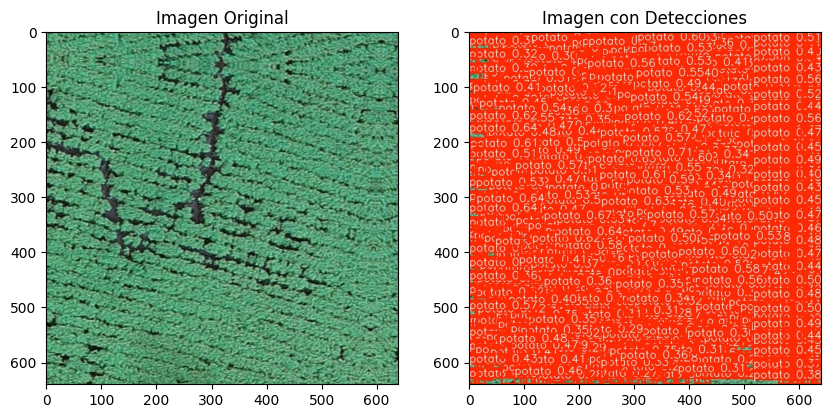


image 1/1 /content/datasets/images/test/19_crop_11_aug_4.jpg: 640x640 1252 potatos, 14.0ms
Speed: 1.7ms preprocess, 14.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict3


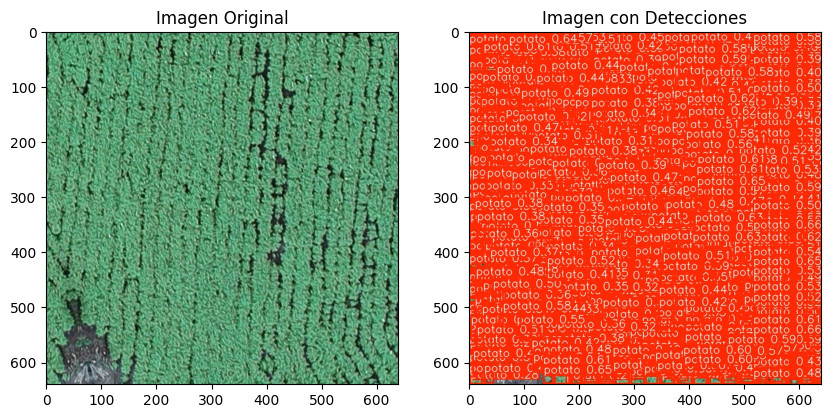

In [ ]:
import cv2
test_folder = '/content/datasets/images/test/'
images_toevaluate=["17_crop_11_aug_1.jpg","19_crop_11_aug_4.jpg"]
for image_path in images_toevaluate:
    # Realizar predicción en la imagen
    results = bestmodel.predict(test_folder+image_path,save=True,stream=False,max_det=1500)#Se coloca save=True para que se guarde la imagen de salida
    # Mostrar la imagen original
    img = cv2.imread(test_folder+image_path)
    # Mostrar la imagen original
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Imagen Original')
    # Mostrar la imagen con las detecciones
    plt.subplot(1, 2, 2)
    img_detect = cv2.imread(results[0].save_dir+'/'+image_path)#Obtenemos la informacion de la imagen guardadad ue es concatenar el path de la prediccion + el nombre de la imagen
    plt.imshow(img_detect)
    plt.title('Imagen con Detecciones')
    plt.show()

In [ ]:
bestmodel.save(f"{ROOT_DIR}/best_proyecto_conaumentacion.pt")